In [6]:
from docarray import BaseDoc, DocList
from docarray.typing import ImageUrl,  ImageNdArray
from vislearnlabpy.models.clip_model import CLIPGenerator
from vislearnlabpy.embeddings.stimuli_loader import StimuliLoader
from PIL import Image
from docarray.utils.find import find
from glob import glob

In [7]:
class CLIPEmbedding(BaseDoc):
    image_embedding: ImageNdArray[512]
    image_url: ImageUrl


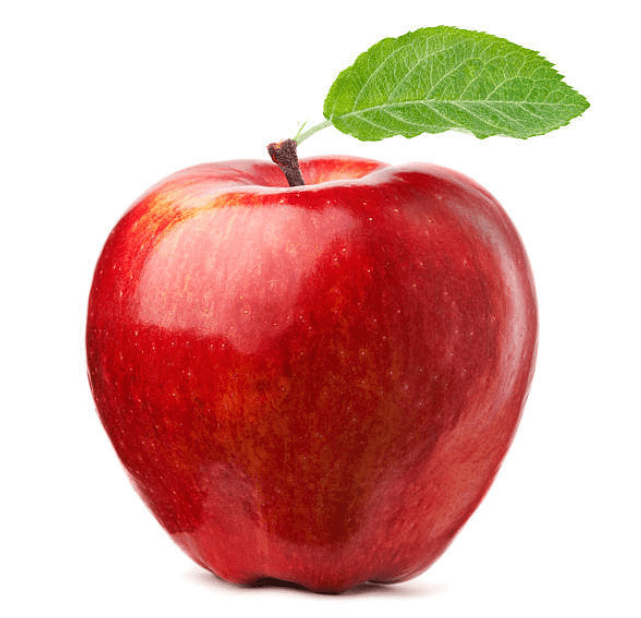

In [8]:
from docarray.documents import ImageDoc
image = ImageDoc(
    url='https://github.com/docarray/docarray/blob/main/tests/toydata/image-data/apple.png?raw=true'
)
image.tensor = image.url.load()
image.tensor.display()
clip_embeddings = DocList[CLIPEmbedding]()

In [10]:
from torchvision import transforms

(CLIPGenerator(device="cuda:0").image_embeddings(images=[transforms.ToPILImage()(image.tensor).convert("RGB")])[0][0]).cpu().numpy().shape

None


(512,)

In [11]:
clip_embeddings
from tqdm import tqdm

In [12]:

files = glob('left/*.jpg') + glob('right/*.jpg')
clip_generator = CLIPGenerator(device="cuda:0")
for file in tqdm(files):
    image = Image.open(file).convert("RGB")
    embedding = clip_generator.image_embeddings(images=[image])[0][0].cpu().numpy()

    # Create the document
    doc = CLIPEmbedding(
        image_url=file,
        image_embedding=embedding
    )
    clip_embeddings.append(doc)
    

None


100%|██████████| 12032/12032 [01:33<00:00, 128.73it/s]


In [21]:
clip_embeddings.push("file:///labs/vislearnlab/experiments/vllpy/ttld-clip")

{}

In [22]:
clip_pulled = DocList[CLIPEmbedding]().pull("file:///labs/vislearnlab/experiments/vllpy/ttld-clip")

In [34]:
from docarray.index import InMemoryExactNNIndex
from docarray.typing import NdArray
import numpy as np


doc_index = InMemoryExactNNIndex[CLIPEmbedding]()
doc_index.index(clip_embeddings)

In [54]:
text_query = "big large alligator"
query = clip_generator.text_embeddings([text_query])[0][0].cpu().numpy()
retrieved_docs, scores = doc_index.find(query, search_field='image_embedding', limit=10)

In [55]:
from PIL import Image
from IPython.display import display, HTML, clear_output
import os
import time

clear_output(wait=True)
html = "<table><tr>"
temp_files = []
for i, (img_path, score) in enumerate(zip(retrieved_docs.image_url, scores)):
    try:
        img = Image.open(img_path)
        img.thumbnail((200, 200))  # Resize for display

        # Save to temporary resized file
        timestamp = int(time.time())
        temp_path = f"_temp_{timestamp}_{i}.png"  # Unique filename per reload
        temp_files.append(temp_path)
        img.save(temp_path)
        # Add image + score in table cell
        html += f"""
        <td style='text-align: center; padding: 10px;'>
            <img src='{temp_path}'><br>
            <span>Alignment: {score:.2f}</span>
        </td>
        """

        if (i + 1) % 3 == 0:
            html += "</tr><tr>"

    except Exception as e:
        print(f"Error loading {img_path}: {e}")

html += "</tr></table>"
display(HTML(html))
time.sleep(1.5)
for f in temp_files:
    try:
        os.remove(f)
    except Exception as e:
        print(f"Could not delete temp file {f}: {e}")